# Fine-Tuning on Recorded Data

In [1]:
# Imports
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

import kerascnn2c
from pathlib import Path
import copy


In [2]:
def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x

## Read Data

In [3]:
data_dir = '../../data/fine-tuning/fine-tune_small.pkl'

with open(data_dir, 'rb') as file:
    data = pickle.load(file)
file.close()

x = data['x']
y = data['y']

permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]

min_int16 = fixed_point_conversion(-(2**15), 9)
max_int16 = fixed_point_conversion((2**15)-1, 9)

scaler = MinMaxScaler(feature_range=(min_int16, max_int16))

x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')


X shape: (147, 16000, 1)
Y shape: (147, 4)


In [4]:
# splitting into training and validation data
train_split = int(0.8*len(x))

x_train, x_val = x[:train_split,:], x[train_split:,:]
y_train, y_val = y[:train_split,:], y[train_split:,:]

print(f'X train: {x_train.shape}')
print(f'X val: {x_val.shape}')
print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (117, 16000, 1)
X val: (30, 16000, 1)
y train: (117, 4)
y val: (30, 4)


In [5]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Create a basic model instance
checkpoint_path = '../models/test/pre-trained/'


model = keras.models.load_model(checkpoint_path)
model.summary

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-30 13:52:04.920278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-30 13:52:04.920396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x15fd17040>>

In [7]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=1, batch_size=1, validation_data=(x_val, y_val))

# model.save('../models/checkpoints-v2/fine-tuned')

2023-04-30 13:52:05.745166: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-30 13:52:06.048466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/117 [============================>.] - ETA: 0s - loss: 1.3352 - categorical_accuracy: 0.4912

2023-04-30 13:52:08.032649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 3s 14ms/step - loss: 1.3453 - categorical_accuracy: 0.4872 - val_loss: 0.8091 - val_categorical_accuracy: 0.5000


In [8]:
with tf.device('/gpu:0'):
    model.evaluate(x_val, y_val, verbose=2)
    pred_test = model.predict(x_val)
    print(tf.math.confusion_matrix(y_val.argmax(axis=1), pred_test.argmax(axis=1)))

1/1 - 0s - loss: 0.8091 - categorical_accuracy: 0.5000 - 237ms/epoch - 237ms/step


2023-04-30 13:52:08.439578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 99ms/step
tf.Tensor(
[[10  0  3]
 [ 0  0  0]
 [12  0  5]], shape=(3, 3), dtype=int32)


2023-04-30 13:52:08.668511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


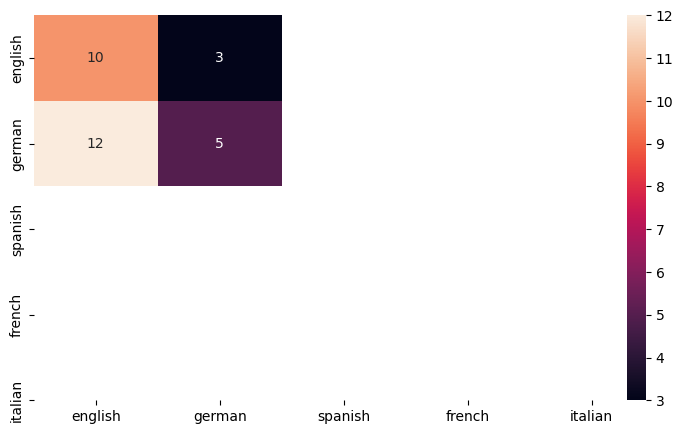

In [9]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

CLASSES = ['english', 'german', 'spanish', 'french', 'italian']

preds = model.predict(x_val)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_val.argmax(axis=-1), y_pred = y_classes)

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=CLASSES, yticklabels=CLASSES)
plt.show()

In [10]:
model.save('./keras2c/lab_gsc_no_globalavg.h5')

# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [11]:
FIXED_POINT=9
res = kerascnn2c.Converter(output_path=Path('keras2c/gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open('keras2c/gsc_model_fixed.h', 'w') as f:
    f.write(res)

INFO:tensorflow:Assets written to: ram://ca1dc9fb-a02f-4bd4-9a5d-abdf79c9158d/assets


INFO:tensorflow:Assets written to: ram://ca1dc9fb-a02f-4bd4-9a5d-abdf79c9158d/assets


———————————————————————————————————————————————————————————————————————————————————————————————————————
Inputs                           | Layer                            | Outputs                         
———————————————————————————————————————————————————————————————————————————————————————————————————————
                                 | input_11                         | conv1d_27                       
-------------------------------------------------------------------------------------------------------
input_11                         | conv1d_27                        | max_pooling1d_21                
-------------------------------------------------------------------------------------------------------
conv1d_27                        | max_pooling1d_21                 | conv1d_28                       
-------------------------------------------------------------------------------------------------------
max_pooling1d_21                 | conv1d_28                        